# XXZ300: ClassiFIM and other methods

## Init

In [1]:
import classifim.bench.fidelity
import classifim.bench.metric
import classifim.bench.peaks
import classifim.bench.plot_tools
import classifim.datasets
import classifim.utils
import classifim.xxz1d
import concurrent.futures
import datasets
import datetime
import importlib
import itertools
import json
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os.path
import pandas as pd
import re
import seaborn as sns
import sklearn.cluster
import sys
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

In [2]:
DATA_DIR0 = classifim.utils.find_data_dir()
DATA_DIR = os.path.join(DATA_DIR0, "xxz_300")
assert os.path.isdir(DATA_DIR)
config_device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(f"Cuda is" + ("" if torch.cuda.is_available() else " NOT") + f" available; setting config_device = '{config_device}'.")
SM_NAME = "xxz_300_z"
PARAMETER_GRID = [(0., 1., 64)] * 2
PARAMETER_GRID_EXPANDED = [np.linspace(*g) for g in PARAMETER_GRID]

Cuda is NOT available; setting config_device = 'cpu'.


/home/victor/.local/opt/mambaforge/envs/classifim/lib/python3.10/site-packages/torch/cuda/__init__.py:107: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at /home/conda/feedstock_root/build_artifacts/pytorch-recipe_1680572619157/work/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


## Example: loading the data

In [3]:
d_train_ds = datasets.load_dataset(
    'fiktor/FIM-Estimation',
    'xxz_300_z.seed05', split='train')
d_train = classifim.datasets.dataset_huggingface_to_dict(d_train_ds)

## Benchmarking

### Load FIM

In [4]:
gt_fims, gt_fim_mgrids = classifim.datasets.load_gt_fims(sm_name=SM_NAME)
print(f"Loaded gt_fims for seeds {list(gt_fims.keys())}.")

Generating test split:   0%|          | 0/16002 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/16002 [00:00<?, ? examples/s]

Loaded gt_fims for seeds [3, 4].


In [5]:
# Load estimated FIM:
FIM_DIR = os.path.join(DATA_DIR, "fim")
ML_NAME = "simple_conv1d"
ml_fims, ml_fim_mgrids = classifim.bench.fidelity.read_ml_fims(
    FIM_DIR,
    f"^{ML_NAME}_" + r"(pauli|z)_[0-9]*(_e[0-9]*)?$",
    ignore_prefix=f"{ML_NAME}_")

### 1D "phase" diagrams

* Requires:
    - Run "Load FIM" section above
* Produces 1D plots of ground truth and predicted fidelity susceptibility.

Saved to '/media/victor/ssd_T7_Victor/d/qc4ml/bschifc_data/neurips2023/xxz_300/figs/fim_simple_conv1d_lambda1_30b-6_thin.png'


{'file_name': '/media/victor/ssd_T7_Victor/d/qc4ml/bschifc_data/neurips2023/xxz_300/figs/fim_simple_conv1d_lambda1_30b-6_thin.png'}

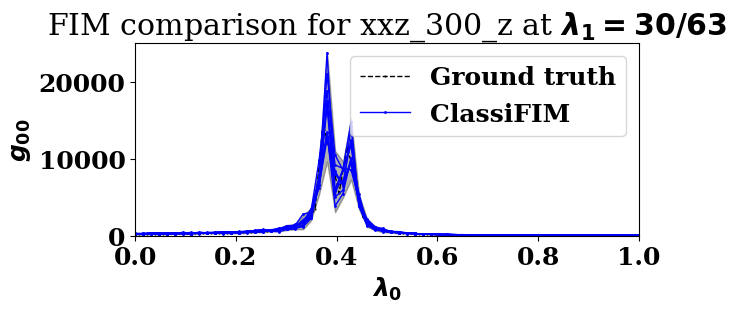

In [6]:
font = {'family' : 'serif', 'weight' : 'bold', 'size'   : 18}
matplotlib.rc('font', **font)

FIG_DIR = classifim.utils.maybe_create_subdir(DATA_DIR, "figs")
file_name = os.path.join(FIG_DIR, f"fim_{ML_NAME}_" + "lambda{fixed_lambda_index}_{fixed_lambda_int_val}b-6_thin.png")
classifim.bench.plot_tools.plot_fim_df_1d(
    gt_fims[3],
    [v for i in range(6, 16) if (v := ml_fims.get(f"z_{i}")) is not None],
    fixed_lambda=(1, 30),
    resolution=63,
    ymax=25000,
    sm_name=SM_NAME,
    file_name=file_name,
    figsize=(6.5,2.5),
    savefig_kwargs={"dpi": 600},
    verbose=True # Change to True to print the file name
)

### 2D "phase" diagrams

* Requires:
    - Run "Load FIM" section above
* Produces 2D plots of ground truth and predicted fidelity susceptibility.

Saved to '/media/victor/ssd_T7_Victor/d/qc4ml/bschifc_data/neurips2023/xxz_300/figs/phase_z_6_e200.png'.


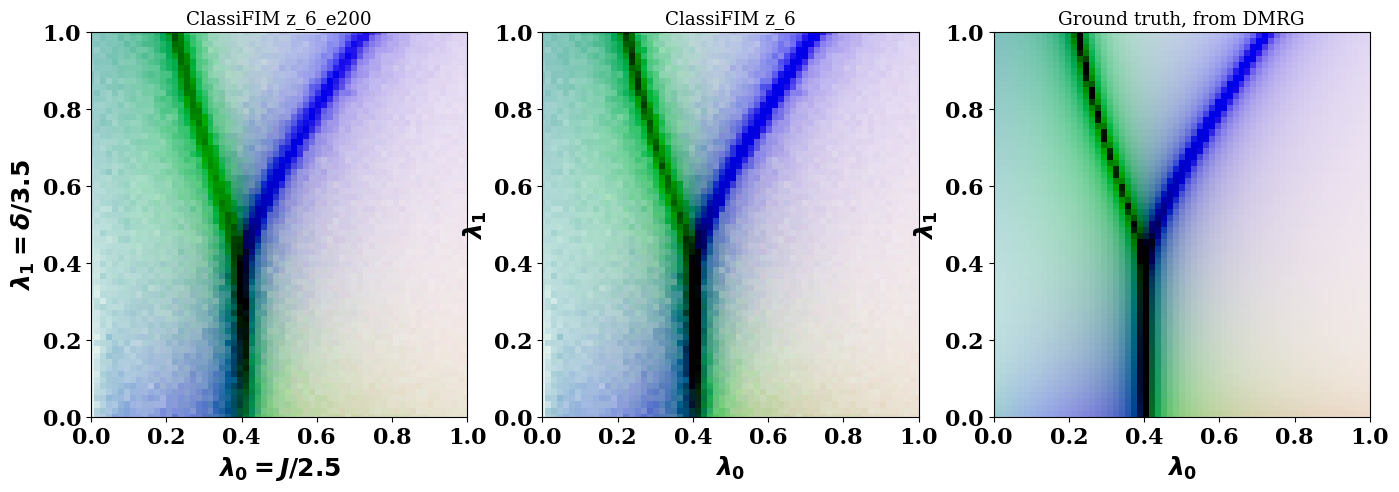

In [10]:
FIG_DIR = classifim.utils.maybe_create_subdir(DATA_DIR, "figs")
res = plt.rcParams.update({'font.size': 11})
fig, axs = plt.subplots(ncols=3, figsize=(3 * 5.5, 5))
(ax0, ax1, ax2) = axs

zz_max = 54
am_pairs = [(ax0, "z_6_e200"), (ax1, "z_6")]
for ax, ml_name in am_pairs:
    classifim.bench.plot_tools.plot_fim_mgrid(ax, ml_fim_mgrids[ml_name], zz_max=zz_max, xlim=(0, 1), ylim=(0, 1))
    ax.set_title(f"ClassiFIM {ml_name}")
ml_fim_seed = am_pairs[0][1]

ax0.set_xlabel("$\lambda_0 = J / 2.5$")
ax0.set_ylabel("$\lambda_1 = \delta / 3.5$")

classifim.bench.plot_tools.plot_fim_mgrid(
    ax2, gt_fim_mgrids[3], zz_max=zz_max, xlim=(0, 1), ylim=(0, 1))
ax2.set_title("Ground truth, from DMRG")

file_name = os.path.join(FIG_DIR, f"phase_{ml_fim_seed}.png")
fig.savefig(file_name, bbox_inches='tight', dpi=600)
print(f"Saved to '{file_name}'.")

### W

In [11]:
def plot_w2d(ax, npz, sweep_axis=0, colorbar=False, cbar_ax=None):
    x, y, z = [
        npz[key]
        for key in ['lambda_sweep_thresholds', 'lambda_fixed', 'accuracy']]
    if sweep_axis != 0:
        assert sweep_axis == 1
        x, y, z = y, x, z.T
    pc = ax.pcolormesh(
        x, y, z,
        cmap=classifim.bench.plot_tools.spiral_background2_cmap,
        shading='nearest', vmin=0.75, vmax=1.0)
    if colorbar:
        fig = ax.get_figure()
        if cbar_ax:
            fig.colorbar(pc, cax=cbar_ax)
        else:
            fig.colorbar(pc)
    return pc

def plot_w1d(ax, npz, sweep_axis=0, lambda_v=47/63):
    x = npz['lambda_sweep_thresholds']
    i = np.searchsorted(npz['lambda_fixed'], lambda_v)
    if i + 1 < len(npz['lambda_fixed']):
        v, vnext = npz['lambda_fixed'][i:i+2]
        if abs(v - lambda_v) > abs(vnext - lambda_v):
            i += 1
    acc = npz['accuracy'][i]
    acc_min = np.min(acc)
    ax.plot(x, acc)
    ax.set_xlim((0, 1))
    ax.set_ylim((max(0.75, acc_min - 0.01), 1))

# fig, ax = plt.subplots()
# plot_w1d(ax, npz)

Saved to '/media/victor/ssd_T7_Victor/d/qc4ml/bschifc_data/neurips2023/xxz_300/figs/xxz_phase_z_6_e5_0_w.png'.


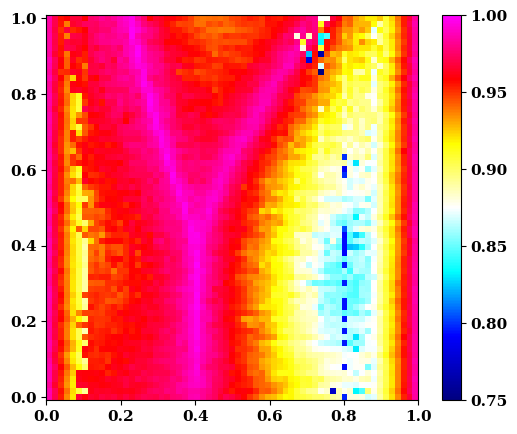

In [12]:
MODELS_DIR = os.path.join(DATA_DIR, "models")
with np.load(os.path.join(MODELS_DIR, "w_z_6_e5_0.w.npz")) as f:
    npz = dict(f)
fig, ax = plt.subplots(ncols=1, figsize=(6, 5))
plot_w2d(ax, npz, colorbar=True)
filename = os.path.join(DATA_DIR, "figs", f"xxz_phase_z_6_e5_0_w.png")
fig.savefig(filename, bbox_inches="tight", dpi=600)
print(f"Saved to '{filename}'.")

### Train logs

In [23]:
import classifim.train_logs
importlib.reload(classifim.train_logs)
MODELS_DIR = os.path.join(DATA_DIR, "models")
train_logs_df = classifim.train_logs.read_logs(MODELS_DIR, permissive=True)
train_logs_df[["sample_type", "seed"]] = train_logs_df["seed"].str.split('_', expand=True)
train_logs_df["seed"] = train_logs_df["seed"].astype(int)
train_logs_summary_df = classifim.train_logs.aggregate_logs(train_logs_df, keys=["name", "model_type", "num_epochs", "sample_type"])
train_logs_summary_df

train_ce  train_ce.std  \
name          model_type num_epochs sample_type                           
simple_conv1d ClassiFIM  200        pauli        0.125249           NaN   
                                    z            0.095004      0.000292   
                         400        z            0.094624      0.000196   
                         580        pauli        0.121480      0.001066   
                                    z            0.094478      0.000119   
w             W          2          z            0.486304      0.039590   
                         5          z            0.201286      0.073139   

                                                      train_n   train_n.std  \
name          model_type num_epochs sample_type                               
simple_conv1d ClassiFIM  200        pauli        9.287640e+05           NaN   
                                    z            1.022551e+06  31107.718647   
                         400        z            1.031936e+06     14.990367   
                         580        pauli        1.031941e+06     14.397531   
                                    z            1.031939e+06     21.970688   
w             W          2          z            7.977000e+03     48.083261   
                         5          z            2.580480e+05      0.000000   

                                                  test_ce  test_ce.std  \
name          model_type num_epochs sample_type                          
simple_conv1d ClassiFIM  200        pauli        0.124949          NaN   
                                    z            0.094841     0.000159   
                         400        z            0.094567     0.000128   
                         580        pauli        0.121512     0.001135   
                                    z            0.094404     0.000122   
w             W          2          z                 NaN          NaN   
                         5          z                 NaN          NaN   

                                                     test_n     test_n.std  \
name          model_type num_epochs sample_type                              
simple_conv1d ClassiFIM  200        pauli         9287476.0            NaN   
                                    z            10225536.0  311126.603552   
                         400        z            10319403.0      80.472217   
                         580        pauli        10319398.8      83.964013   
                                    z            10319403.0      80.472217   
w             W          2          z                  -1.0       0.000000   
                         5          z                  -1.0       0.000000   

                                                        time    time.std  cnt  
name          model_type num_epochs sample_type                                
simple_conv1d ClassiFIM  200        pauli        2355.895616         NaN    1  
                                    z             759.865345  580.981685   11  
                         400        z            2161.603501    1.884024   10  
                         580        pauli        3125.577866    2.526057   10  
                                    z            3126.184172    2.343304   10  
w             W          2          z              54.361356    0.778708    2  
                         5          z            1176.555433   15.959419   20

### Compute dist metrics

* Requires:
    - Run "Load FIM" section above
* Produces: `metrics/dist_res.npz` with distSE values, distMSE & distRE metrics

In [10]:
METRICS_DIR = classifim.utils.maybe_create_subdir(DATA_DIR, "metrics")

In [15]:
def unroll_dict(d, key_name):
    res = {}
    for key in next(iter(d.values())).keys():
        res[key] = np.array([r[key] for r in d.values()])
    res[key_name] = np.array(list(d.keys()))
    return res

In [29]:
%%time
dist_res = {}
for ml_fim_seed in [f"z_{i}_e400" for i in range(6, 16)]:
    prng = classifim.utils.DeterministicPrng(ml_fim_seed)
    cur_res = classifim.bench.metric.compute_distance_errors(
        grid=PARAMETER_GRID,
        ml_fim_mgrids[ml_fim_seed], gt_fim_mgrids[3], num_pairs=4334, # 838656,
        seed=prng.get_seed("compute_distance_errors"), use_cpp=True)
    dist_res[ml_fim_seed] = cur_res

CPU times: user 9.75 s, sys: 6.55 ms, total: 9.76 s
Wall time: 9.78 s


In [12]:
dist_res2 = {}

In [13]:
%%time
def compute_distance_errors_wrapper(ml_fim_seed):
    prng = classifim.utils.DeterministicPrng(ml_fim_seed)
    cur_res = classifim.bench.metric.compute_distance_errors(
        ml_fim_mgrids[ml_fim_seed], gt_fim_mgrids[3], num_pairs=8386560,
        seed=prng.get_seed("compute_distance_errors"), use_cpp=True)
    return ml_fim_seed, cur_res
with concurrent.futures.ThreadPoolExecutor() as executor:
    ml_fim_seeds = [f"z_{i}_e400" for i in range(6, 16)]
    for ml_fim_seed, cur_res in executor.map(compute_distance_errors_wrapper, ml_fim_seeds):
        dist_res2[ml_fim_seed] = cur_res

CPU times: user 6h 30min 10s, sys: 57.2 s, total: 6h 31min 7s
Wall time: 3h 26min 19s


In [27]:
dist_res_dict = unroll_dict(dist_res, "ml_fim_seed")
dist_res_dict2 = unroll_dict(dist_res2, "ml_fim_seed")

In [28]:
for key in list(dist_res_dict.keys()):
    print(f"{key}: {np.array_equal(dist_res_dict[key], dist_res_dict2[key])}")

num_pairs: True
lambda_pairs: True
distances: True
distMSE: True
distRE: True
distMSE_const: True
distRE_const: True
distRE_perfect: True
distMSE_perfect_scale: True
scale: True
ml_chifc_seed: True


In [25]:
dist_res_dict2 = unroll_dict(dist_res2, "ml_fim_seed")
DIST_RES_PATH = os.path.join(METRICS_DIR, "dist_res_e580f.npz") # "dist_res.npz")
np.savez_compressed(DIST_RES_PATH, **dist_res_dict2)

In [21]:
DIST_RES_PATH = os.path.join(METRICS_DIR, "dist_res_e580f.npz") # "dist_res.npz")
with np.load(DIST_RES_PATH) as npz:
    dist_res_dict2 = dict(npz)

In [24]:
dist_res_dict2['ml_fim_seed'] = [f"z_{i}" for i in range(6, 16)]

### Print dist metrics

In [20]:
METRICS_DIR = os.path.join(DATA_DIR, "metrics")
def load_metric_df(name):
    dist_res_filename = os.path.join(METRICS_DIR, f"{name}.npz")
    with np.load(dist_res_filename) as f:
        df = {
            key: value
            for key in f.keys()
            if key not in ["lambda_pairs", "distances"]
                and len((value := f[key]).shape) == 1
        }
    if "ml_chifc_seed" in df and "ml_fim_seed" not in df:
        df["ml_fim_seed"] = df["ml_chifc_seed"]
        del df["ml_chifc_seed"]
    df = pd.DataFrame(df)
    df.set_index("ml_fim_seed", inplace=True)
    return df

def print_latex_summary(df):
    for column_name, values in df.items():
        digits = 4
        if 'distRE' in column_name:
            digits = 4
            values = values * 100
            column_name = column_name + r" (\%)"
        elif column_name.startswith("num_"):
            digits = 0
        print(f"{column_name}: ${classifim.bench.metric.normal_summary(values, digits=digits)}$")
        
def decode_ml_fim_name(full_name):
    # Splitting the string by '_' and checking the last part for an 'e' followed by a number
    parts = full_name.split('_')
    if parts[-1].startswith('e'):
        try:
            # Extracting the number of epochs
            num_epochs = int(parts[-1][1:])
            dataset_name = '_'.join(parts[:-1])
        except ValueError:
            # In case the part after 'e' is not a number, default to 580 epochs
            num_epochs = 580
            dataset_name = full_name
    else:
        # Default number of epochs
        num_epochs = 580
        dataset_name = full_name

    return dataset_name, num_epochs

In [21]:
combined_dist_metrics = []
for i, name in enumerate(["dist_res_e580f", "dist_res_e400f", "dist_res_e200f"]):
    df = load_metric_df(name)
    combined_dist_metrics.append(df)
    if i:
        print()
    print(f"{name}:")
    print_latex_summary(df)
combined_dist_metrics = pd.concat(combined_dist_metrics)
combined_dist_metrics["dataset"], combined_dist_metrics["num_epochs"] = (
    zip(*(decode_ml_fim_name(s) for s in combined_dist_metrics.index)))
combined_dist_metrics.set_index(["dataset", "num_epochs"], inplace=True, verify_integrity=True)

dist_res_e580f:
num_pairs: $8386560 \pm 0$
distMSE: $0.3902 \pm 0.0690$
distRE (\%): $1.2722 \pm 0.0715$
distMSE_const: $41.3071 \pm 0.0000$
distRE_const (\%): $24.5467 \pm 0.0000$
distRE_perfect (\%): $0.0000 \pm 0.0000$
distMSE_perfect_scale: $0.3571 \pm 0.0393$
scale: $0.9909 \pm 0.0108$

dist_res_e400f:
num_pairs: $8386560 \pm 0$
distMSE: $0.3722 \pm 0.0447$
distRE (\%): $1.2417 \pm 0.0770$
distMSE_const: $41.3071 \pm 0.0000$
distRE_const (\%): $24.5467 \pm 0.0000$
distRE_perfect (\%): $0.0000 \pm 0.0000$
distMSE_perfect_scale: $0.3599 \pm 0.0458$
scale: $1.0040 \pm 0.0079$

dist_res_e200f:
num_pairs: $8386560 \pm 0$
distMSE: $0.7798 \pm 0.1654$
distRE (\%): $1.4199 \pm 0.1123$
distMSE_const: $41.3071 \pm 0.0000$
distRE_const (\%): $24.5467 \pm 0.0000$
distRE_perfect (\%): $0.0000 \pm 0.0000$
distMSE_perfect_scale: $0.5719 \pm 0.0883$
scale: $1.0364 \pm 0.0097$


In [45]:
cf_train_logs = train_logs_df[(train_logs_df["model_type"] == "ClassiFIM") & (train_logs_df["sample_type"] == "z")].copy()
cf_train_logs["dataset"] = [st + "_" + str(seed) for (st, seed) in zip(cf_train_logs["sample_type"], cf_train_logs["seed"])]
classifim_metrics2 = cf_train_logs.join(combined_dist_metrics, on=["dataset", "num_epochs"], validate="1:1")

### Best possible cross entropy error

TODO:9
* Requires:
    - Ground state probabilities in 'lanczos' dir
    - Test dumps (produced by `twelve_sites_classifim.ipynb`) at `classifim_datasets/test_dump_{seed}.npz`. TODO:8
* Prints out best possible cross entropy error (for an algorithm which knows ground state probabilities).

In [11]:
%%time
DATASETS_DIR = os.path.join(DATA_DIR, "classifim_datasets")
assert os.path.isdir(DATASETS_DIR)
best_xes = {}
for seed in range(6, 16):
    res = classifim_gen.fil24_hamiltonian.compute_best_possible_xe(
        dump_npz=np.load(os.path.join(DATASETS_DIR, f"test_dump_{seed}.npz")),
        zs_to_vi_f=lambda zs: ham_family.z_to_vi[ham_family.unrepack_z_for_classifim(zs)],
        lambdas_to_params_f=param_conversions.lambdas_to_params,
        probs_cache=get_lanczos_cache(),
        resolution=64)
    best_xes[seed] = res

FileNotFoundError: [Errno 2] No such file or directory: '/media/victor/ssd_T7_Victor/d/qc4ml/bschifc_data/neurips2023/xxz1d/classifim_datasets/test_dump_42.npz'

In [12]:
v = np.array(list(best_xes.values()))
summary = classifim.bench.metric.normal_summary(v)
print(f"Best possible XE: {summary}")

Best possible XE: nan \pm nan


/home/victor/.local/opt/mambaforge/envs/classifim/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/victor/.local/opt/mambaforge/envs/classifim/lib/python3.10/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/victor/.local/opt/mambaforge/envs/classifim/lib/python3.10/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/victor/.local/opt/mambaforge/envs/classifim/lib/python3.10/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/victor/.local/opt/mambaforge/envs/classifim/lib/python3.10/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encount

## Comparison with prior works

### Huang's PCA

In [15]:
def plot_pca(ax, pca):
    n0, n1, num_components = pca.shape
    assert n0 == 64
    assert n1 == 64
    assert num_components >= 3
    pca3 = pca[:, :, :3]
    z = pca3 - np.min(pca3, axis=(0, 1))
    z = z / np.max(z, axis=(0, 1))
    ax.pcolormesh(*PARAMETER_GRID_EXPANDED, z.swapaxes(0, 1), shading="nearest")
    ax.set_xlabel(r"$\lambda_0$")
    ax.set_ylabel(r"$\lambda_1$")
    ax.set_title("XXZ phase diagram from PCA")

In [16]:
MODELS_DIR = os.path.join(DATA_DIR, "models")
with np.load(os.path.join(MODELS_DIR, "pcaz_k_shadow_z_5.npz")) as f:
    pca = f["pca"]
    suffix = f["suffix"]

Saved to '/media/victor/ssd_T7_Victor/d/qc4ml/bschifc_data/neurips2023/xxz1d/figs/xxz_phase_z_5_pca.png'.


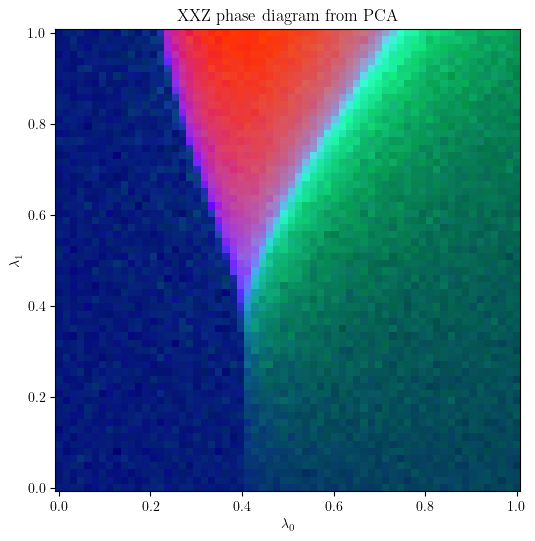

In [17]:
fig, ax = plt.subplots(figsize=(6, 6))
plot_pca(ax, pca)
filename = os.path.join(DATA_DIR, "figs", f"xxz_phase_{suffix}_pca.png")
fig.savefig(filename, bbox_inches="tight", dpi=600)
print(f"Saved to '{filename}'.")

### GT peaks

In [47]:
importlib.reload(classifim.bench.peaks)
gt_peaks = {}
for sweep_lambda_index in [0, 1]:
    for seed, gt_fim in gt_fims.items():
        gt_mg = classifim.bench.peaks.extract_gt_meshgrid(
            gt_fim, sweep_lambda_index=sweep_lambda_index)
        gt_peaks[seed, sweep_lambda_index] = classifim.bench.peaks.get_gt_peaks(
            gt_mg=gt_mg, min_prominence=1.0)

Note: gt_peaks depends only on sweep_lambda_index:

In [48]:
for sweep_lambda_index in [0, 1]:
    for k, v0 in gt_peaks[3, 0].items():
        v1 = gt_peaks[4, 0][k]
        if not np.array_equal(v0, v1):
            print("Seeds differ for sli={sweep_lambda_index}, {k=}")

Let's make it official:

In [49]:
gt_peaks = {sli: v for (seed, sli), v in gt_peaks.items() if seed == 3}
assert len(gt_peaks) == 2

#### SPCA

In [50]:
sweep_lambda_index = 1
cur_gt_peaks = gt_peaks[sweep_lambda_index]
MODELS_DIR = os.path.join(DATA_DIR, "models")
dataset_name = "z_5"
pca_filename = f"pcaz_k_shadow_{dataset_name}.npz"
with np.load(os.path.join(MODELS_DIR, pca_filename)) as f:
    pca = f["pca"]
pca_peaks = classifim.bench.peaks.get_pca_peaks(
    grid=PARAMETER_GRID, pca=pca[:, :, :2],
    num_peaks=cur_gt_peaks["num_peaks"],
    postprocess=True,
    sweep_lambda_index=sweep_lambda_index)

Saved to /media/victor/ssd_T7_Victor/d/qc4ml/bschifc_data/neurips2023/xxz_300/figs/xxz300_pca_peaks_1.png.


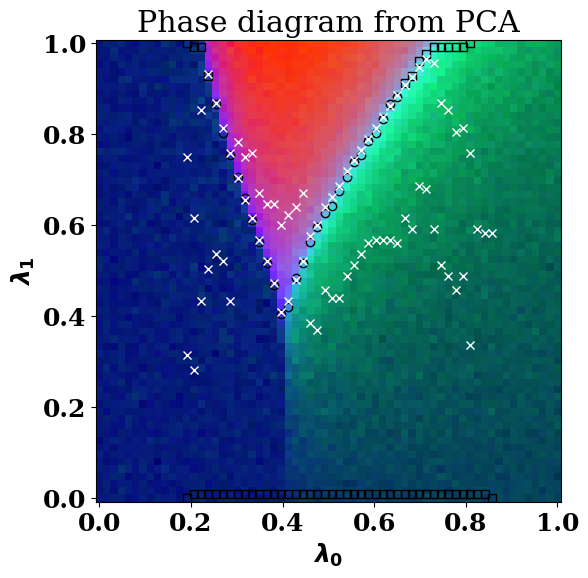

In [51]:
importlib.reload(classifim.bench.plot_tools)
fig, ax = plt.subplots(figsize=(6, 6))
classifim.bench.plot_tools.plot_pca(ax, pca)
classifim.bench.plot_tools.plot_gt_peaks_2d(
    ax, sweep_lambda_index=sweep_lambda_index, gt_peaks=cur_gt_peaks)
xs, ys = pca_peaks["lambda_sweep"], pca_peaks["lambda_fixed"]
if sweep_lambda_index:
    xs, ys = ys, xs
ax.plot(xs, ys, 'x', mfc='none', mec='white')
file_name = os.path.join(DATA_DIR, "figs", f"xxz300_pca_peaks_{sweep_lambda_index}.png")
fig.savefig(file_name, bbox_inches="tight", dpi=600)
print(f"Saved to {file_name}.")

#### Peak locations

In [53]:
%%time
importlib.reload(classifim.bench.peaks)
MODELS_DIR = os.path.join(DATA_DIR, "models")
all_peak_errors = []
for seed, (sweep_lambda_index, cur_gt_peaks) in itertools.product(
        range(6, 16), gt_peaks.items()):
    assert sweep_lambda_index in [0, 1]
    gt_num_peaks, gt_lambda_fixed = [
        cur_gt_peaks[key] for key in ["num_peaks", "lambda_fixed"]]
    dataset_name = f"z_{seed}"
    cur_peaks = {}
    methods = []
    for ml_suffix2 in ("", "_e200", "_e400"):
        method_name = f"ml{ml_suffix2}"
        methods.append(method_name)
        ml_mg = classifim.bench.peaks.extract_ml_meshgrid(
            ml_fim_mgrids[dataset_name + ml_suffix2], sweep_lambda_index)
        ml_peaks, ml_smooth_peaks = [
            classifim.bench.peaks.get_classifim_peaks(
                ml_mg,
                num_peaks=gt_num_peaks,
                lambda_fixed_expected=gt_lambda_fixed,
                lambda_fixed_tolerance=2**(-23), # np.float32 ulp
                postprocess=postprocess)
            for postprocess in [False, True]]
        cur_peaks[f"{method_name}_peaks"] = ml_peaks
        cur_peaks[f"{method_name}_smooth_peaks"] = ml_smooth_peaks
    methods.append("w")
    w_filename = f"w_{dataset_name}_e5_{sweep_lambda_index}.w.npz"
    with np.load(os.path.join(MODELS_DIR, w_filename)) as f:
        w_npz = dict(f)
    cur_peaks["w_peaks"], cur_peaks["w_smooth_peaks"] = [
        classifim.bench.peaks.get_w_peaks(
            lambda_fixed=w_npz["lambda_fixed"],
            lambda_sweep=w_npz["lambda_sweep_thresholds"],
            w_accuracy=w_npz["accuracy"],
            num_peaks=gt_num_peaks,
            lambda_fixed_expected=gt_lambda_fixed,
            postprocess=postprocess,
            xrange=[cur_gt_peaks[key] for key in ["xmin", "xmax"]])
        for postprocess in [False, True]]
    methods.append("pca")
    pca_filename = f"pcaz_k_shadow_{dataset_name}.npz"
    with np.load(os.path.join(MODELS_DIR, pca_filename)) as f:
        pca = f["pca"]
    cur_peaks["pca_peaks"], cur_peaks["pca_smooth_peaks"] = [
        classifim.bench.peaks.get_pca_peaks(
            grid=PARAMETER_GRID, pca=pca[:, :, :2], num_peaks=cur_gt_peaks["num_peaks"],
            postprocess=postprocess, sweep_lambda_index=sweep_lambda_index)
        for postprocess in [False, True]]
    peak_errors = classifim.bench.peaks.compute_peak_rmses(cur_gt_peaks, cur_peaks)
    peak_errors["seed"] = seed
    peak_errors["sweep_lambda_index"] = sweep_lambda_index
    peak_errors["num_peaks"] = np.sum(cur_gt_peaks["is_inner"])
    peak_errors["num_peaks_single"] = np.sum(
        cur_gt_peaks["is_inner"] & cur_gt_peaks["is_single"])
    peak_errors["methods"] = methods
    all_peak_errors.append(peak_errors)

/home/victor/Dropbox (Lidar group)/qc4ml_work/bs_chifc/classifim/src/classifim/bench/peaks.py:582: UserWarning: No ground truth values selected.
  warnings.warn("No ground truth values selected.")
/home/victor/Dropbox (Lidar group)/qc4ml_work/bs_chifc/classifim/src/classifim/bench/peaks.py:582: UserWarning: No ground truth values selected.
  warnings.warn("No ground truth values selected.")
/home/victor/Dropbox (Lidar group)/qc4ml_work/bs_chifc/classifim/src/classifim/bench/peaks.py:582: UserWarning: No ground truth values selected.
  warnings.warn("No ground truth values selected.")
/home/victor/Dropbox (Lidar group)/qc4ml_work/bs_chifc/classifim/src/classifim/bench/peaks.py:582: UserWarning: No ground truth values selected.
  warnings.warn("No ground truth values selected.")
/home/victor/Dropbox (Lidar group)/qc4ml_work/bs_chifc/classifim/src/classifim/bench/peaks.py:582: UserWarning: No ground truth values selected.
  warnings.warn("No ground truth values selected.")
/home/victor/Dr

CPU times: user 1min 41s, sys: 5.25 s, total: 1min 46s
Wall time: 17.9 s


/home/victor/Dropbox (Lidar group)/qc4ml_work/bs_chifc/classifim/src/classifim/bench/peaks.py:582: UserWarning: No ground truth values selected.
  warnings.warn("No ground truth values selected.")


In [54]:
importlib.reload(classifim.bench.peaks)
peak_metrics_df_raw = classifim.bench.peaks.peak_errors2d_to_df(all_peak_errors)
peak_metrics_df = classifim.bench.peaks.peak_errors2d_agg_sweeps(peak_metrics_df_raw)

In [55]:
peak_metrics_df

,seed,method_name,num_rows,num_peaks,num_peaks_single,peaks,smooth_peaks,peaks_single,smooth_peaks_single
0,6,ml,2,126,28,0.009327,0.008061,0.008999,0.004974
1,6,ml_e200,2,126,28,0.008659,0.007279,0.007937,0.004500
2,6,ml_e400,2,126,28,0.008425,0.007999,0.008999,0.006708
3,6,pca,2,126,28,0.021069,0.011947,0.042528,0.020837
4,6,w,2,126,28,0.070111,0.008396,0.003674,0.003000
5,7,ml,2,126,28,0.008659,0.007176,0.007937,0.004500
6,7,ml_e200,2,126,28,0.009746,0.009486,0.007937,0.004500
7,7,ml_e400,2,126,28,0.008887,0.007035,0.008999,0.005408
8,7,pca,2,126,28,0.023492,0.010804,0.048089,0.018185
9,7,w,2,126,28,0.040233,0.007905,0.034202,0.004242


In [56]:
classifim.bench.peaks.paired_t_tests(peak_metrics_df, metric_name="smooth_peaks", verbose=True);

ml vs ml_e200: 0.008 ≈ 0.008 (t-stat=-0.644, p=0.536)
ml vs ml_e400: 0.008 ≈ 0.008 (t-stat=1.514, p=0.164)
ml vs pca: 0.008 < 0.012 (t-stat=-6.054, p=0.000)
ml vs w: 0.008 < 0.011 (t-stat=-3.474, p=0.007)
ml_e200 vs ml_e400: 0.008 ≈ 0.008 (t-stat=1.539, p=0.158)
ml_e200 vs pca: 0.008 < 0.012 (t-stat=-5.094, p=0.001)
ml_e200 vs w: 0.008 < 0.011 (t-stat=-2.800, p=0.021)
ml_e400 vs pca: 0.008 < 0.012 (t-stat=-5.933, p=0.000)
ml_e400 vs w: 0.008 < 0.011 (t-stat=-3.329, p=0.009)
pca vs w: 0.012 ≈ 0.011 (t-stat=0.906, p=0.388)


In [57]:
metric_names = ["peaks", "peaks_single", "smooth_peaks", "smooth_peaks_single"]
dfg = peak_metrics_df.groupby("method_name").agg(
    **{k: (k, "mean") for k in ["num_peaks", "num_peaks_single"]},
    **{
        metric + ("" if fun == "mean" else "." + fun): (metric, fun)
        for metric in metric_names
        for fun in ["mean", "std"]})
dfg

,num_peaks,num_peaks_single,peaks,peaks.std,peaks_single,peaks_single.std,smooth_peaks,smooth_peaks.std,smooth_peaks_single,smooth_peaks_single.std
method_name,,,,,,,,,,
ml,126.0,28.0,0.008814,0.000341,0.008574,0.000549,0.007811,0.000498,0.004825,0.000936
ml_e200,126.0,28.0,0.009273,0.000475,0.008149,0.000448,0.008043,0.000747,0.004601,0.001106
ml_e400,126.0,28.0,0.008762,0.000486,0.008362,0.000549,0.007512,0.000480,0.004816,0.001105
pca,126.0,28.0,0.020890,0.002815,0.042403,0.006234,0.011865,0.002172,0.020230,0.005493
w,126.0,28.0,0.052853,0.011290,0.009423,0.009864,0.010888,0.003004,0.005068,0.001566


### ClassiFIM metrics: logs + dist + peaks

Requires:
* `classifim_metrics2` from "Print dist metrics" section
* `peak_metrics_df` from GT peaks section

In [65]:
print(list(classifim_metrics2.columns))

['filename_stem', 'seed', 'num_epochs', 'model_type', 'train_ce', 'train_n', 'test_ce', 'test_n', 'time', 'sample_type', 'dataset', 'num_pairs', 'distMSE', 'distRE', 'distMSE_const', 'distRE_const', 'distRE_perfect', 'distMSE_perfect_scale', 'scale']


In [85]:
if "name" in classifim_metrics2:
    del classifim_metrics2["name"]
df = peak_metrics_df
df = df[df["method_name"].map(lambda s: s.startswith("ml"))].copy()
df["dataset"] = [f"z_{s}" for s in df["seed"]]
df["num_epochs"] = df["method_name"].map(lambda s: int(m.group(1)) if (m := re.match(r"^ml_e(\d+)$", s)) else 580)
del df["method_name"]
join_keys = ["num_epochs", "dataset", "seed"]
df.set_index(join_keys, inplace=True, verify_integrity=True)
classifim_metrics3 = classifim_metrics2.join(df, on=join_keys, validate="1:1")
classifim_metrics3.set_index(join_keys, inplace=True, verify_integrity=True)
classifim_metrics3.sort_index(inplace=True)

In [76]:
classifim_metrics3

filename_stem model_type  train_ce  \
num_epochs dataset seed                                                 
200        z_10    10    simple_conv1d_z_10_e200  ClassiFIM  0.095170   
           z_11    11    simple_conv1d_z_11_e200  ClassiFIM  0.095098   
           z_12    12    simple_conv1d_z_12_e200  ClassiFIM  0.095231   
           z_13    13    simple_conv1d_z_13_e200  ClassiFIM  0.094575   
           z_14    14    simple_conv1d_z_14_e200  ClassiFIM  0.095035   
           z_15    15    simple_conv1d_z_15_e200  ClassiFIM  0.094796   
           z_5     5           simple_conv1d_z_5  ClassiFIM  0.094942   
           z_6     6      simple_conv1d_z_6_e200  ClassiFIM  0.095205   
           z_7     7      simple_conv1d_z_7_e200  ClassiFIM  0.095415   
           z_8     8      simple_conv1d_z_8_e200  ClassiFIM  0.094448   
           z_9     9      simple_conv1d_z_9_e200  ClassiFIM  0.095134   
400        z_10    10    simple_conv1d_z_10_e400  ClassiFIM  0.094711   
           z_11    11    simple_conv1d_z_11_e400  ClassiFIM  0.094881   
           z_12    12    simple_conv1d_z_12_e400  ClassiFIM  0.094833   
           z_13    13    simple_conv1d_z_13_e400  ClassiFIM  0.094287   
           z_14    14    simple_conv1d_z_14_e400  ClassiFIM  0.094604   
           z_15    15    simple_conv1d_z_15_e400  ClassiFIM  0.094326   
           z_6     6      simple_conv1d_z_6_e400  ClassiFIM  0.094616   
           z_7     7      simple_conv1d_z_7_e400  ClassiFIM  0.094573   
           z_8     8      simple_conv1d_z_8_e400  ClassiFIM  0.094630   
           z_9     9      simple_conv1d_z_9_e400  ClassiFIM  0.094773   
580        z_10    10         simple_conv1d_z_10  ClassiFIM  0.094693   
           z_11    11         simple_conv1d_z_11  ClassiFIM  0.094592   
           z_12    12         simple_conv1d_z_12  ClassiFIM  0.094389   
           z_13    13         simple_conv1d_z_13  ClassiFIM  0.094356   
           z_14    14         simple_conv1d_z_14  ClassiFIM  0.094608   
           z_15    15         simple_conv1d_z_15  ClassiFIM  0.094340   
           z_6     6           simple_conv1d_z_6  ClassiFIM  0.094513   
           z_7     7           simple_conv1d_z_7  ClassiFIM  0.094407   
           z_8     8           simple_conv1d_z_8  ClassiFIM  0.094455   
           z_9     9           simple_conv1d_z_9  ClassiFIM  0.094430   

                         train_n   test_ce    test_n         time sample_type  \
num_epochs dataset seed                                                         
200        z_10    10    1031894  0.095178  10319340   482.952456           z   
           z_11    11    1031938  0.095017  10319326   477.182918           z   
           z_12    12    1031928  0.095013  10319402   478.551391           z   
           z_13    13    1031914  0.094704  10319366   478.345187           z   
           z_14    14    1031966  0.094764  10319320   478.340157           z   
           z_15    15    1031922  0.094689  10319344   478.850975           z   
           z_5     5      928758  0.094851   9287454  2354.868573           z   
           z_6     6     1031954  0.094775  10319292  1081.380522           z   
           z_7     7     1031936  0.094798  10319380  1080.100013           z   
           z_8     8     1031960  0.094744  10319298   483.818274           z   
           z_9     9     1031894  0.094715  10319374   484.128330           z   
400        z_10    10    1031922  0.094574  10319394  2161.993303           z   
           z_11    11    1031942  0.094818  10319514  2158.872496           z   
           z_12    12    1031924  0.094541  10319410  2164.652653           z   
           z_13    13    1031942  0.094547  10319380  2161.856186           z   
           z_14    14    1031924  0.094736  10319300  2162.288080           z   
           z_15    15    1031932  0.094369  10319374  2159.886882           z   
           z_6     6     1031930  0.094507  10319292  2164.038892           z   
     

### Metric comparison

In [77]:
def visualize_metrics(dataframe, rename_metrics=None, title=True, yticks=True, xticks=True):
    """
    Visualizes the given DataFrame using box and whisker plots.
    
    Args:
        A pandas DataFrame with multi-index ('num_epochs', 'dataset') and metric columns.
    """
    # Ensuring the DataFrame has the correct structure
    if not isinstance(dataframe.index, pd.MultiIndex):
        raise ValueError("DataFrame must have a multi-index ('num_epochs', 'dataset').")
    num_metrics = min(99, len(dataframe.columns))
    metrics = list(dataframe.columns[:num_metrics])
    dataframe = dataframe.reset_index()

    sns.set(style="whitegrid")
    fig, axes = plt.subplots(ncols=num_metrics, figsize=(2 * num_metrics, 5))

    # Plotting each metric
    for i, metric in enumerate(metrics):
        metric_name = (rename_metrics or {}).get(metric, metric)
        ax = axes[i]
        sns.boxplot(data=dataframe, x="num_epochs", y=metric, ax=ax, orient="v")
        if title:
            ax.set_title(f'{metric_name}')
        if not yticks:
            ax.set(yticklabels=[])
            ax.set(ylabel=None)
            ax.tick_params(left=False)
        if not xticks:
            ax.set(xticklabels=[])
            ax.set(xlabel=None)
            ax.tick_params(bottom=False)
            
    # Adjust layout
    fig.tight_layout()

    # Display the plot
    fig.show()
    return fig

In [78]:
print("', '".join(classifim_metrics3.columns))

filename_stem', 'model_type', 'train_ce', 'train_n', 'test_ce', 'test_n', 'time', 'sample_type', 'num_pairs', 'distMSE', 'distRE', 'distMSE_const', 'distRE_const', 'distRE_perfect', 'distMSE_perfect_scale', 'scale', 'num_rows', 'num_peaks', 'num_peaks_single', 'peaks', 'smooth_peaks', 'peaks_single', 'smooth_peaks_single


/tmp/ipykernel_2227204/581284625.py:38: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


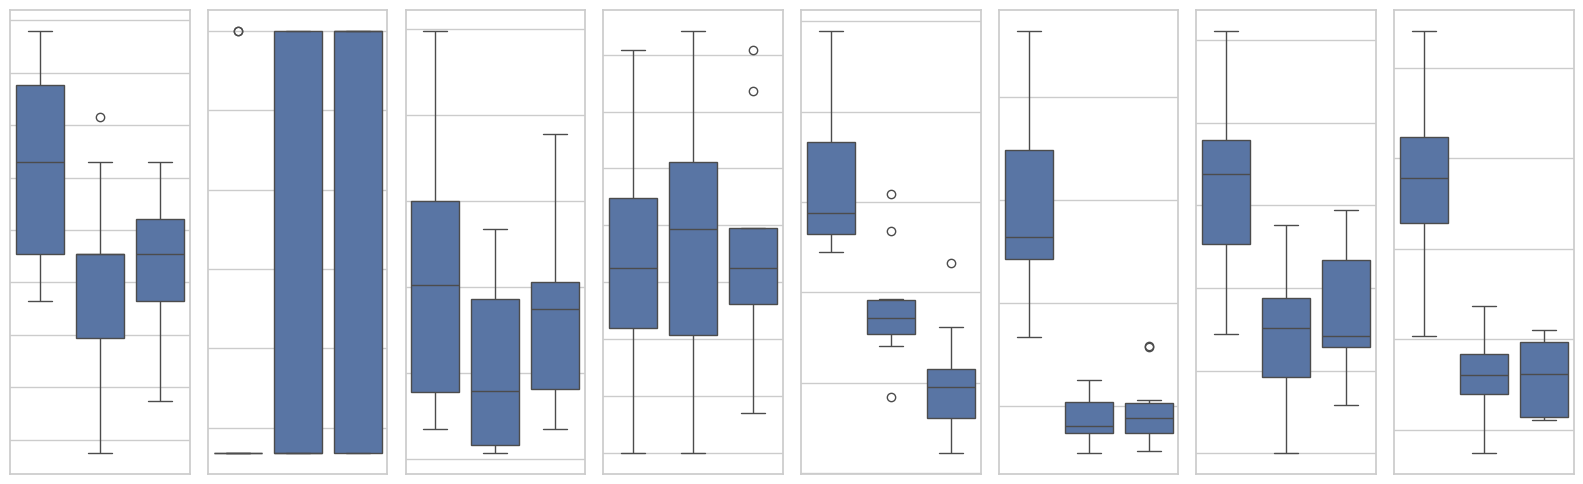

In [79]:
fig = visualize_metrics(
    classifim_metrics3[[
        'peaks', 'peaks_single', 'smooth_peaks', 'smooth_peaks_single',
        'test_ce', 'distMSE', 'distRE', 'distMSE_perfect_scale'
    ]],
    rename_metrics={
        'distMSE_perfect_scale': r'$\mathrm{distMSE}_{\mathrm{PS}}$'},
    title=False, xticks=False, yticks=False
)

In [80]:
FIGS_DIR = classifim.utils.maybe_create_subdir(DATA_DIR, "figs")
fig.savefig(os.path.join(FIGS_DIR, "metrics_comparison_v2.png"), dpi=600, bbox_inches="tight")

In [104]:
import importlib
importlib.reload(classifim.bench.peaks)
df = classifim_metrics3.reset_index()
df = df[~np.isnan(df["distMSE"])]
df = df[[ne in [200, 580] for ne in df["num_epochs"]]]
df["PeakRMSE"] = df["smooth_peaks"]
df["distMSEPS"] = df["distMSE_perfect_scale"]
df["method_name"] = [f"ml_{ne}" for ne in df["num_epochs"]]
metric_names = ["PeakRMSE", "distMSE", "distMSEPS", "distRE"]
df = df[["method_name", "seed"] + metric_names]
for metric_name in metric_names:
    print(f"{metric_name:>9s}: ", end="")
    classifim.bench.peaks.paired_t_tests(
        df, metric_name=metric_name, verbose=True,
        pval_format=".3g")

print_latex_summary(df[df["method_name"] == "ml_200"][metric_names])
print_latex_summary(df[df["method_name"] == "ml_580"][metric_names])

 PeakRMSE: ml_200 vs ml_580: 0.008 ≈ 0.008 (t-stat=0.644, p=0.536)
  distMSE: ml_200 vs ml_580: 0.780 > 0.390 (t-stat=5.936, p=0.000219)
distMSEPS: ml_200 vs ml_580: 0.572 > 0.357 (t-stat=7.292, p=4.6e-05)
   distRE: ml_200 vs ml_580: 0.014 > 0.013 (t-stat=3.978, p=0.00322)
PeakRMSE: $0.0080 \pm 0.0007$
distMSE: $0.7798 \pm 0.1654$
distMSEPS: $0.5719 \pm 0.0883$
distRE (\%): $1.4199 \pm 0.1123$
PeakRMSE: $0.0078 \pm 0.0005$
distMSE: $0.3902 \pm 0.0690$
distMSEPS: $0.3571 \pm 0.0393$
distRE (\%): $1.2722 \pm 0.0715$


### 2D: 2x2

Saved to '/media/victor/ssd_T7_Victor/d/qc4ml/bschifc_data/neurips2023/xxz1d/figs/xxz_phase_1x4.png'.


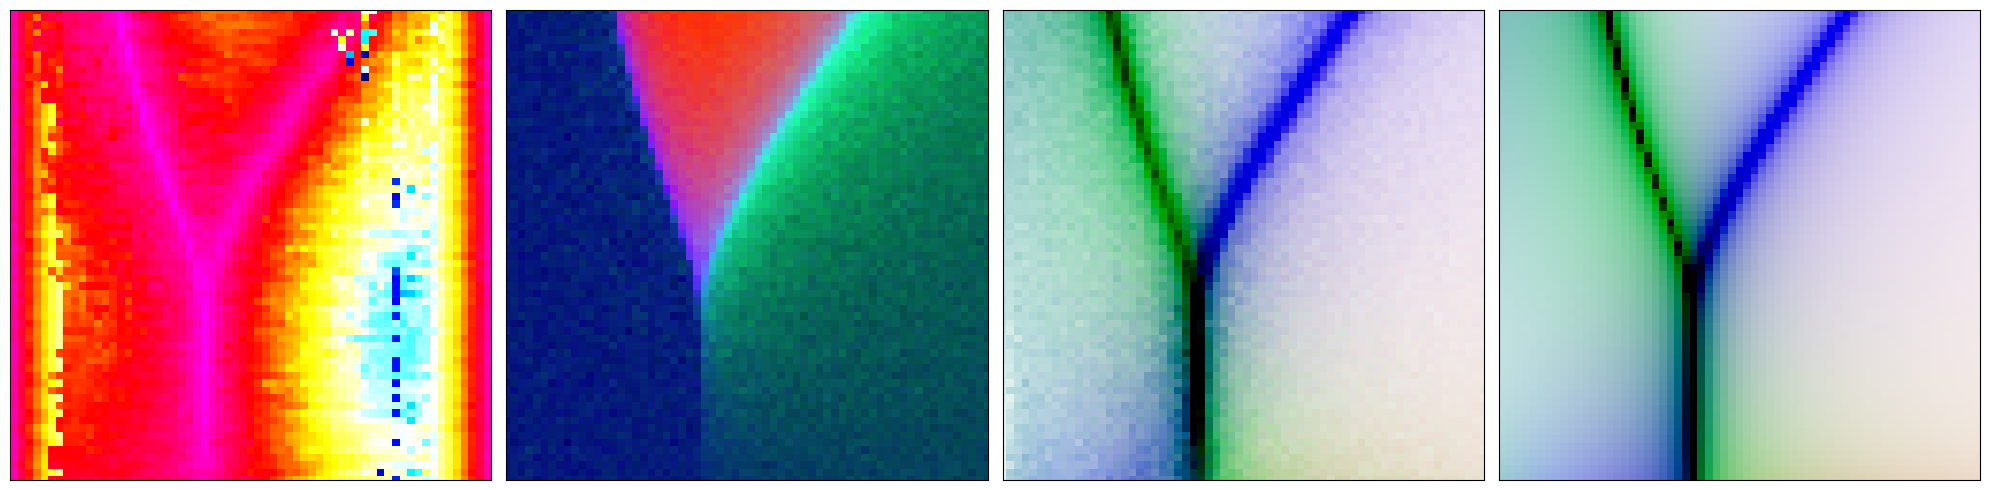

In [65]:
# 1x4
fig, axs = plt.subplots(ncols=4, figsize=(4 * 5, 5))
ax0, ax1, ax2, ax3 = axs
plot_w2d(ax0, npz, colorbar=False)
plot_pca(ax1, pca)
# ax1.set_title("W")
zz_max=54
classifim.bench.plot_tools.plot_fim_mgrid(ax2, ml_fim_mgrids["z_6"], zz_max=zz_max, xlim=(0, 1), ylim=(0, 1))
# ax2.set_title("ClassiFIM")
classifim.bench.plot_tools.plot_fim_mgrid(ax3, gt_fim_mgrids[3], zz_max=zz_max, xlim=(0, 1), ylim=(0, 1))
# ax3.set_title("Ground truth, from DMRG")
for ax in axs:
    ax.set_xlim((0, 1))
    ax.set_ylim((0, 1))
    ax.set(title=None)
    ax.set(yticklabels=[])
    ax.set(ylabel=None)
    ax.tick_params(left=False)
    ax.set(xticklabels=[])
    ax.set(xlabel=None)
    ax.tick_params(bottom=False)
fig.tight_layout()
filename = os.path.join(DATA_DIR, "figs", f"xxz_phase_1x4.png")
fig.savefig(filename, bbox_inches="tight", dpi=600)
print(f"Saved to '{filename}'.")

Saved to '/Volumes/ssd_T7_Victor/d/qc4ml/bschifc_data/neurips2023/xxz1d/figs/xxz_phase_2x2.png'.


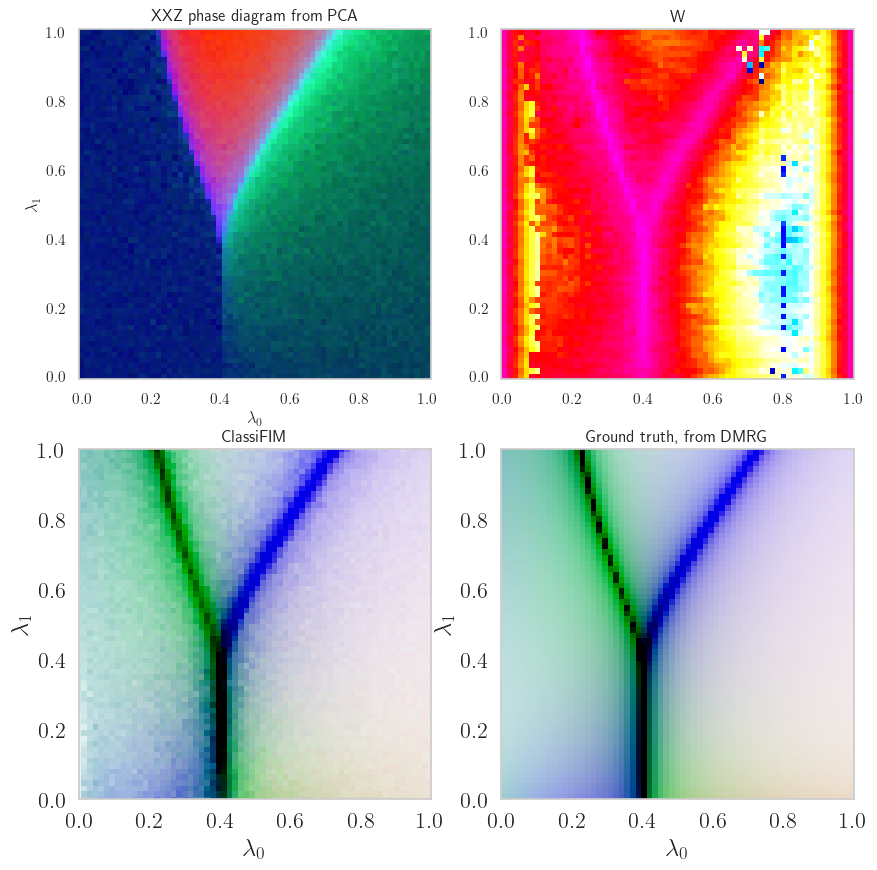

In [250]:
# 2x2
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(10, 10))
(ax0, ax1), (ax2, ax3) = axs
plot_pca(ax0, pca)
plot_w2d(ax1, npz, colorbar=False)
ax1.set_title("W")
zz_max=54
classifim.bench.plot_tools.plot_fim_mgrid(ax2, ml_fim_mgrids["z_6"], zz_max=zz_max, xlim=(0, 1), ylim=(0, 1))
ax2.set_title("ClassiFIM")
classifim.bench.plot_tools.plot_fim_mgrid(ax3, gt_fim_mgrids[3], zz_max=zz_max, xlim=(0, 1), ylim=(0, 1))
ax3.set_title("Ground truth, from DMRG")
filename = os.path.join(DATA_DIR, "figs", f"xxz_phase_2x2.png")
fig.savefig(filename, bbox_inches="tight", dpi=600)
print(f"Saved to '{filename}'.")

Grayed out regions are 2 standard deviations from the mean.
Saved to '/media/victor/ssd_T7_Victor/d/qc4ml/bschifc_data/neurips2023/xxz1d/figs/xxz_phase_1x7.png'.


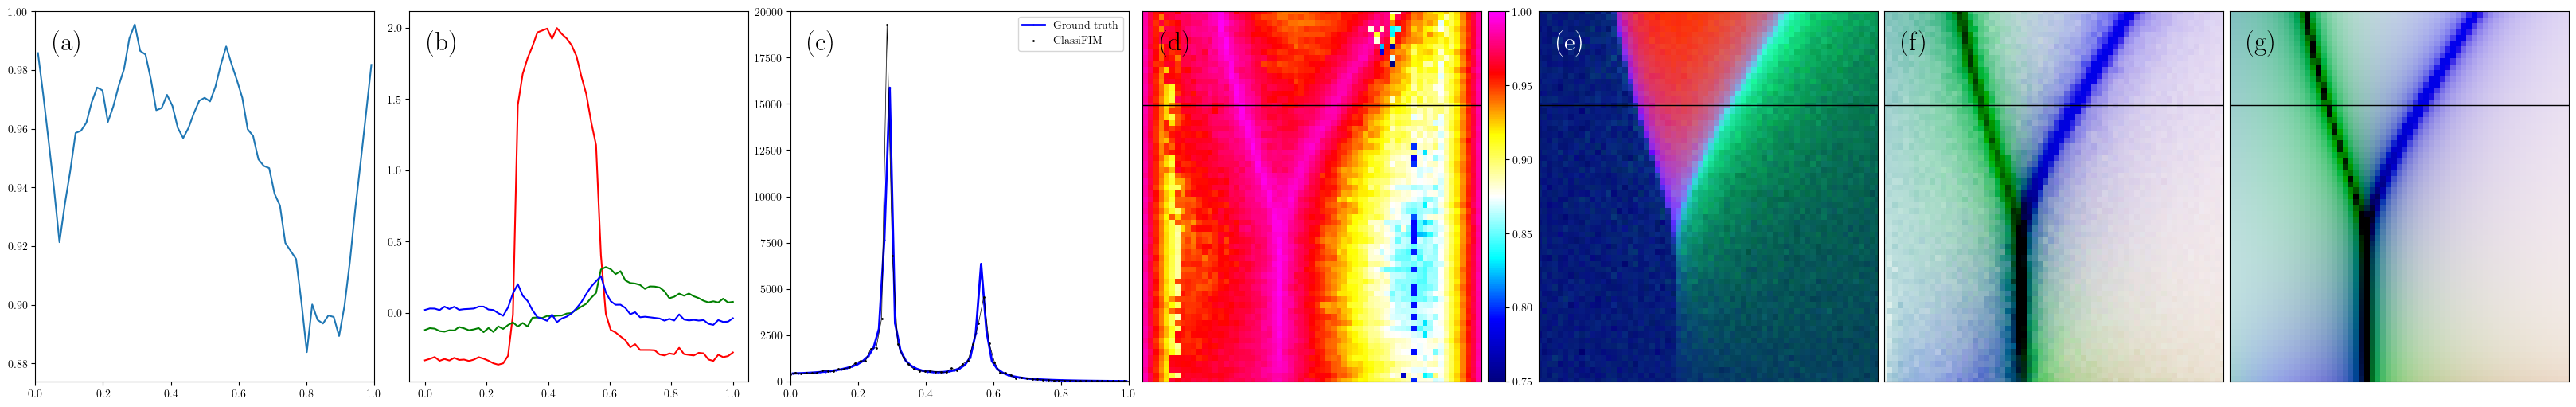

In [66]:
# 1x8 TODO:1
# fig, axs = plt.subplots(ncols=4, figsize=(4 * 5, 5))
fig = plt.figure(figsize=(32.25, 5.0), layout='constrained') # TODO:5:check what constrained_layout does.
gs = matplotlib.gridspec.GridSpec(
    1, 8, width_ratios=[1, 1, 1, 1, 0.05, 1, 1, 1], figure=fig)
axs_1d = [fig.add_subplot(gs[0, i]) for i in [0, 1, 2]]
axs_2d = [fig.add_subplot(gs[0, i]) for i in [3, 5, 6, 7]]
cbar_ax0_2d, = cbar_axs = [fig.add_subplot(gs[0, i]) for i in [4]]

lambda1i = 47
lambda1 = lambda1i / 63
plot_w1d(axs_1d[0], npz, lambda_v=lambda1)
for i in range(3):
    axs_1d[1].plot(np.arange(64) / 63, pca[:, lambda1i, i], color=['red', 'green', 'blue'][i])

classifim.bench.plot_tools.plot_fim_df_1d(
    gt_fims[3],
    [v for i in [6] if (v := ml_fims.get(f"z_{i}")) is not None],
    fixed_lambda=(1, lambda1i),
    resolution=63,
    ymax=20000,
    sm_name=SM_NAME,
    ax=axs_1d[2])
axs_1d[2].set_title(None)
axs_1d[2].set_xlabel(None)
axs_1d[2].set_ylabel(None)

plot_w2d(axs_2d[0], npz, colorbar=True, cbar_ax=cbar_ax0_2d)
plot_pca(axs_2d[1], pca)
# ax1.set_title("W")
zz_max=54
classifim.bench.plot_tools.plot_fim_mgrid(axs_2d[2], ml_fim_mgrids["z_6"], zz_max=zz_max, xlim=(0, 1), ylim=(0, 1))
# ax2.set_title("ClassiFIM")
classifim.bench.plot_tools.plot_fim_mgrid(axs_2d[3], gs_fim_mgrid, zz_max=zz_max, xlim=(0, 1), ylim=(0, 1))
# ax3.set_title("Ground truth, from DMRG")
for ax in axs_2d:
    ax.set_xlim((0, 1))
    ax.set_ylim((0, 1))
    ax.set(title=None)
    ax.set(yticklabels=[])
    ax.set(ylabel=None)
    ax.tick_params(left=False)
    ax.set(xticklabels=[])
    ax.set(xlabel=None)
    ax.tick_params(bottom=False)
    ax.plot([0, 1], [lambda1, lambda1], color='black', linewidth=1)

for i, ax in enumerate(axs_1d + axs_2d):
    panel_label = f'({chr(97 + i)})'  # 97 is the ASCII code for 'a'
    # Position the text at the top left corner of the panel
    # Adjust x and y values as needed to fit your specific figure layout
    ax.text(0.05, 0.95, panel_label, transform=ax.transAxes, fontsize=24,
            verticalalignment='top', horizontalalignment='left',
            color=('white' if ax == axs_2d[1] else 'black'))

filename = os.path.join(DATA_DIR, "figs", f"xxz_phase_1x7.png")
fig.savefig(filename, bbox_inches="tight", dpi=600)
print(f"Saved to '{filename}'.")

In [165]:
w_filename = f"w_z_6_e5_0.w.npz"
with np.load(os.path.join(MODELS_DIR, w_filename)) as f:
    w_npz = dict(f)

Saved to '/media/victor/ssd_T7_Victor/d/qc4ml/bschifc_data/neurips2023/xxz_300/figs/xxz_phase_1x7_paper.png'.


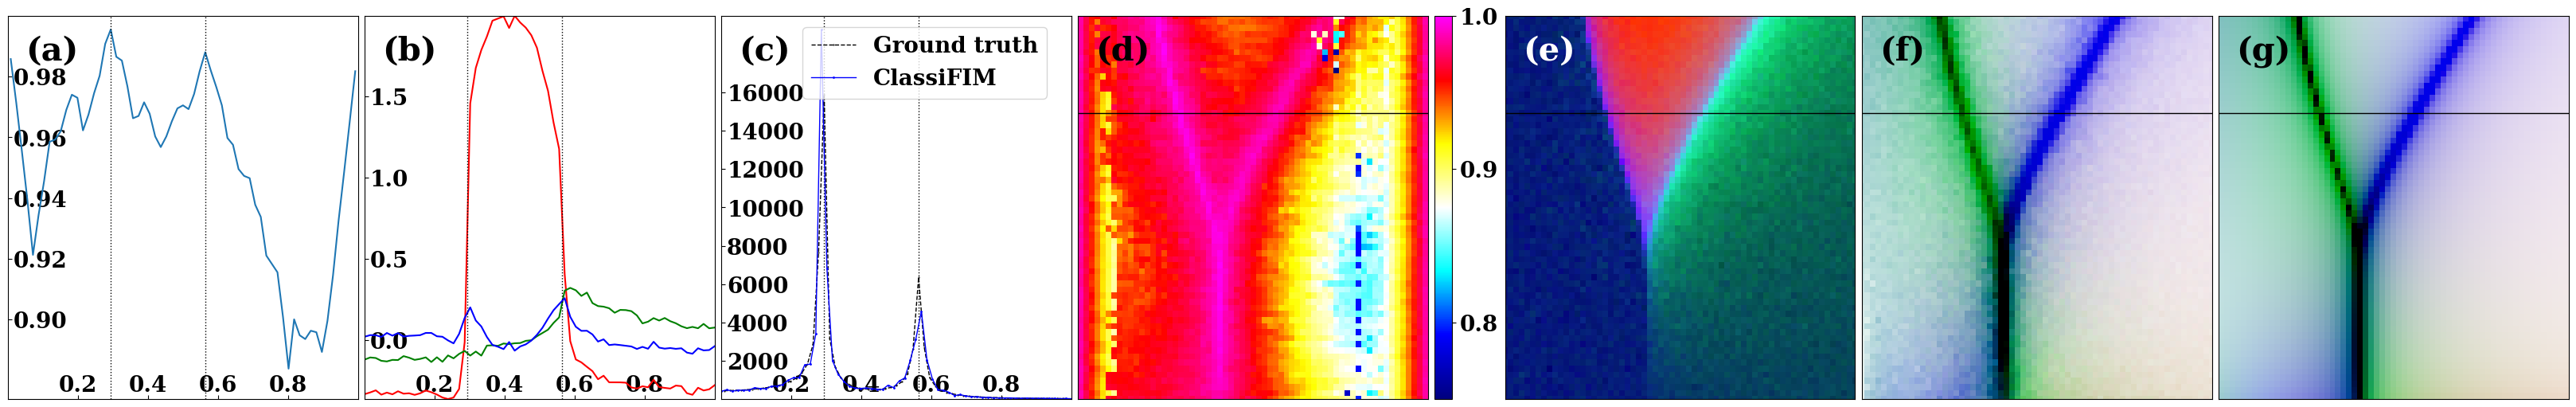

In [172]:
importlib.reload(classifim.bench.plot_tools)
png_scale = 1.0
fig = plt.figure(figsize=(32.25 * png_scale, 5.0 * png_scale), layout='constrained') # TODO:5:check what constrained_layout does.
gs = matplotlib.gridspec.GridSpec(
    1, 8, width_ratios=[1, 1, 1, 1, 0.05, 1, 1, 1], figure=fig)
axs_1d = [fig.add_subplot(gs[0, i]) for i in [0, 1, 2]]
axs_2d = [fig.add_subplot(gs[0, i]) for i in [3, 5, 6, 7]]
cbar_ax0_2d, = cbar_axs = [fig.add_subplot(gs[0, i]) for i in [4]]

lambda1i = 47
lambda1 = PARAMETER_GRID_EXPANDED[1][lambda1i]

# (a)
classifim.bench.plot_tools.plot_w1d(axs_1d[0], w_npz, lambda_v=lambda1)
axs_1d[0].set_yticks(np.linspace(0.9, 0.98, 5))

# (b)
for i in range(3):
    axs_1d[1].plot(PARAMETER_GRID_EXPANDED[0], pca[:, lambda1i, i], color=['red', 'green', 'blue'][i])
axs_1d[1].set_xlim((0, 1))
axs_1d[1].set_ylim((np.min(pca[:, lambda1i, :3]), np.max(pca[:, lambda1i, :3])))
axs_1d[1].set_yticks(np.linspace(0.0, 1.5, 4))

# (c)
ymax = 20000
plot_fim_df_res = classifim.bench.plot_tools.plot_fim_df_1d(
    gt_fims[3],
    [ml_fims["z_6"]],
    fixed_lambda=(1, lambda1i),
    resolution=63,
    ymax=ymax,
    sm_name=SM_NAME,
    fim_vlines=True,
    ax=axs_1d[2])
axs_1d[2].set_title(None)
axs_1d[2].set_xlabel(None)
axs_1d[2].set_ylabel(None)
axs_1d[2].legend(loc='upper left', bbox_to_anchor=(0.2, 1.0), fontsize=20)
axs_1d[2].set_yticks(np.arange(1, 9) * 2e3)

for ax in axs_1d:
    ax.tick_params(axis='x', direction='in', pad=-22, labelsize=20)
    ax.set_xticks([0.2, 0.4, 0.6, 0.8])
    ax.tick_params(axis='y', direction='in', pad=-5, labelsize=20)
    for label in ax.get_yticklabels():
        label.set_horizontalalignment('left')


for ax in axs_1d[:2]:
    for vline in plot_fim_df_res["fim_vlines"]:
        ax.axvline(vline, color='black', linestyle=':', linewidth=1.0)

classifim.bench.plot_tools.plot_w2d(axs_2d[0], w_npz, colorbar=True, cbar_ax=cbar_ax0_2d)
cbar_ax0_2d.tick_params(axis='y', labelsize=20)
cbar_ax0_2d.set_yticks([0.8, 0.9, 1.0])
classifim.bench.plot_tools.plot_pca(axs_2d[1], pca)
# ax1.set_title("W")
zz_max = 54
classifim.bench.plot_tools.plot_fim_mgrid(
    axs_2d[2], ml_fim_mgrids["z_6"], zz_max=zz_max, xlim=(0, 1), ylim=(0, 1))
# ax2.set_title("ClassiFIM")
classifim.bench.plot_tools.plot_fim_mgrid(
    axs_2d[3], gt_fim_mgrids[3], zz_max=zz_max, xlim=(0, 1), ylim=(0, 1))
# ax3.set_title("Ground truth, from DMRG")
for ax in axs_2d:
    ax.set_xlim((0, 1))
    ax.set_ylim((0, 1))
    ax.set(title=None)
    ax.set(yticklabels=[])
    ax.set(ylabel=None)
    ax.tick_params(left=False)
    ax.set(xticklabels=[])
    ax.set(xlabel=None)
    ax.tick_params(bottom=False)
    ax.axhline(lambda1, color='black', linewidth=1)

for i, ax in enumerate(axs_1d + axs_2d):
    panel_label = f'({chr(97 + i)})'  # 97 is the ASCII code for 'a'
    # Position the text at the top left corner of the panel
    # Adjust x and y values as needed to fit your specific figure layout
    ax.text(0.05, 0.95, panel_label, transform=ax.transAxes, fontsize=30,
            verticalalignment='top', horizontalalignment='left',
            color=('white' if ax == axs_2d[1] else 'black'))

filename = os.path.join(DATA_DIR, "figs", f"xxz_phase_1x7_paper.png")
fig.savefig(filename, bbox_inches="tight", dpi=600)
print(f"Saved to '{filename}'.")

### Plot peaks

TODO:9

NameError: name 'do_transpose' is not defined

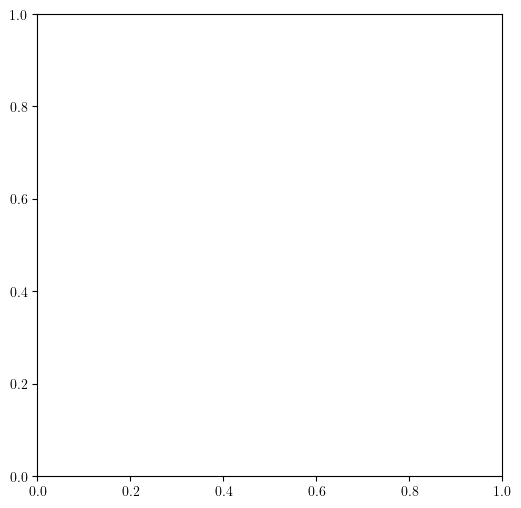

In [36]:
def plot_t(ax, do_transpose, x, y, **kwargs):
    if do_transpose:
        x, y = y, x
    ax.plot(x, y, **kwargs)
def set_xy_labels_t(ax, do_transpose, x_label, y_label):
    if do_transpose:
        x_label, y_label = y_label, x_label
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
fig, ax = plt.subplots(figsize=(6, 6))
plot_t(ax, do_transpose, ml_fim_mgrid[fixed_lambda_name], sweep_lambda_max_ml, color='red',
       label=r'$\mathrm{argmax}(\widehat{\mathrm{FIM}})$')
plot_t(ax, do_transpose, gs_mg[fixed_lambda_name], sweep_lambda_max_gs, color='green',
       label=r'$\mathrm{argmax}(\mathrm{FIM})$')
set_xy_labels_t(ax, do_transpose, f"${lambda_fixed_latex}$ (fixed)", "$\\lambda_{" + f"{sweep_lambda_index:d}" + "}$ (sweep)")
ax.set_xlim((0, 1))
ax.set_ylim((0, 1))
ax.legend()
filename = "lambda_sweep_root.png"
fig.savefig(filename)
print(f"Saved fig to {os.path.realpath(filename)}")

# Scratch

In [71]:
gt_peaks[1]

{'lambda_fixed_ii': array([12, 12, 13, 13, 14, 14, 15, 15, 16, 16, 17, 17, 18, 18, 19, 19, 20,
        20, 21, 21, 22, 22, 23, 23, 24, 24, 25, 25, 26, 26, 27, 27, 28, 28,
        29, 29, 30, 30, 31, 31, 32, 32, 33, 33, 34, 34, 35, 35, 36, 36, 37,
        37, 38, 38, 39, 39, 40, 40, 41, 41, 42, 42, 43, 43, 44, 44, 45, 45,
        46, 46, 47, 47, 48, 48, 49, 49, 50, 50, 51, 51, 52, 53, 54]),
 'lambda_fixed': array([0.19047619, 0.19047619, 0.20634921, 0.20634921, 0.22222222,
        0.22222222, 0.23809524, 0.23809524, 0.25396825, 0.25396825,
        0.26984127, 0.26984127, 0.28571429, 0.28571429, 0.3015873 ,
        0.3015873 , 0.31746032, 0.31746032, 0.33333333, 0.33333333,
        0.34920635, 0.34920635, 0.36507937, 0.36507937, 0.38095238,
        0.38095238, 0.3968254 , 0.3968254 , 0.41269841, 0.41269841,
        0.42857143, 0.42857143, 0.44444444, 0.44444444, 0.46031746,
        0.46031746, 0.47619048, 0.47619048, 0.49206349, 0.49206349,
        0.50793651, 0.50793651, 0.52380952, 0.5